# PBHspec: MWE

This notebook presents a minimal code that allows reproducing the results described in [arXiv:2504.13251](https://arxiv.org/abs/2504.13251). The model parameters considered below are the ones used in our companion paper [arXiv:2512.04199](https://arxiv.org/abs/2512.04199) (Table I).

The computation is performed using the PyTransport package of [arXiv:1609.00379](https://arxiv.org/pdf/1609.00379). The setup file for the PBH$A$ model considered in our work is provided.
Refer to the [PyTransport repository](https://github.com/jronayne/PyTransport) for further information and to instal and use the package.

Note that this is a crude (and self-contained) version of the code developed by the authors as an extension of the PyTransport package; a complete version of such code will be released at a later date. Notice that all quantities are calculated using the number of e-folds, $N$, as a time coordinate.


The authors: Dario Lorenzoni, Sarah Geller, David Kaiser, Evan McDonough

For information and assistance, contact: lorenzod@myumanitoba.ca

### Setup

In [1]:
# Import useful packages:
import matplotlib.pyplot as plt  # import package for plotting
from pylab import *              # contains some useful functions for plotting
import time                      # to see how long processes take
import math                      # imports math package
import numpy as np               # imports numpy package
import sys                       # imports sys package for use below
from scipy.interpolate import UnivariateSpline # for numerical interpolation

# This path must point to the location of the user's installation of PyTransport:
location = "path/to/PyTransport/PyTransport"
sys.path.append(location)        # sets up python path to give access to PyTransSetup

import PyTransSetup
PyTransSetup.pathSet()           # sets the other paths that PyTransport uses
import PyTransScripts as PyS     # import the scripts module as PyS for convenience

######################## Set up the inflationary model: ############################
# Choose inflationary model:
import PyTrans_PBHAspec as PyT   # import the compiled module for the chosen model
####################################################################################

In [2]:
# Set useful constants:
Mp = 1                           # set M_Planck=1 throughout
nF = 2                           # number of fields: 2 fields in the system
nP = 7                           # number of parameters: 7 parameters in the model
tols = np.array([1e-10,1e-10])   # numerical accuracy for the computations

Nstar = 56                       # exit of CMB scales, as calculated both analytically and numerically
kCMB = 0.05                      # comoving CMB pivot scale [Mpc^-1]

Nstart = 0                       # start background evolution computation at N=0
Nendmax = 200                    # compute background evolution until at most N=200
Npoints = 100000                 # number of points to compute for the background calculation
t = np.linspace(Nstart, Nendmax, Npoints) # array of time (N_e) coordinates for the bckgr calc.
stop_at_end = True               # set the background evolution calculation to stop when eps=1

nmodes = 100                     # number of k-modes to compute for the power spectrum PRk

In [3]:
# Define useful functions:

def find_index(arr, val):
    # Helper function: find index of a value withing an array
    closest_val = min(arr, key=lambda x: abs(x - val))
    index = np.where(arr == closest_val)[0][0]
    return index

def hubble_(back, params):
    # Define H using the PyT function
    H_array = np.zeros(len(back[:,0]))
    for i in range(len(back[:,0])):
        H_array[i] = PyT.H(np.array([back[i,j] for j in range(1, 2*nF+1)]), params)
    return H_array

def epsilon_(back, params):
    # Define epsilon using the PyT function
    eps_array = np.zeros(len(back[:,0]))
    for i in range(len(back[:,0])):
        eps_array[i] = PyT.Ep(np.array([back[i,j] for j in range(1, 2*nF+1)]), params)
    return eps_array

def eta_(back, params, eps):
    # Define eta as \eta= 2\eps - \dot{\eps}/(2 H \eps)
    etaFun = UnivariateSpline(back[:,0], np.log(eps), k=4, s=1e-15).derivative()
    return 2*eps - 0.5*etaFun(back[:,0])

def omega_(back):
    # Define scaled turn rate \omega/H
    theta = np.arccos(back[:,3] / np.sqrt(back[:,3]**2 + back[:,4]**2))
    OmegaFun = UnivariateSpline(back[:,0], theta, k=4, s=1e-15).derivative()
    return -OmegaFun(back[:,0])

def PRkN_(back, params, NExit=55, NBD=4.0, npoints=1000, tols=np.array([1e-10,1e-10])):
    # Calculate the time-dependent power spectrum for one k-mode
    k = np.exp(back[-1,0]-NExit) * hubble_(back, params)[find_index(back[:,0], back[-1,0]-NExit)]
    #k = PyS.kexitN(back[-1,0]-NExit, back, params, PyT)
    Nstart, backExitMinus = PyS.ICsBE(NBD, k, back, params, PyT) # find conditions before horizon crossing
    tsig = np.linspace(Nstart, back[-1,0], npoints) # time (N_e) array for PRk(N) computation
    Nx = back[-1,0]-tsig
    Pz = PyT.sigEvolve(tsig, k, backExitMinus, params, tols, True)[:,1] # dim.ful power spectrum
    calP = k**3 * Pz / (2.*np.pi**2) # dimensionless power spectrum
    return calP, Nx

def PRk_(back, params, n_modes, N_star=55, NBD=4.0, kCMB=0.05, tols=np.array([1e-10,1e-10])):
    # Calculate curvature power spectrum
    kOut = np.array([])
    NeHX = np.array([])
    for Nx in np.linspace(0, N_star-5, n_modes):
        NExit = N_star - Nx
        NeHX = np.append(NeHX, NExit) # this builds an array of different NExit times
        #k = PyS.kexitN(back[-1,0]-NExit, back, params, PyT)
        k = np.exp(back[-1,0]-NExit) * hubble_(back, params)[find_index(back[:,0], back[-1,0]-NExit)]
        kOut = np.append(kOut, k)  # this builds an array of ks associated with different NExit times
    Pz, times = PyS.pSpectra(kOut, back, params, NBD, tols, PyT)
    calP = kOut ** 3 * Pz / (2. * np.pi ** 2) # dimensionless power spectrum
    return calP, kOut, NeHX

def CMBobs_(back, params, n_modes, N_star=55, tols=np.array([1e-20,1e-20]), d=0.25):
    # Calculate CMB observables (compute 7 modes around Nstar to calculate obs at Nstar)
    prk, ks, nehx = np.array([PRk_(back, params, 1, N_star=Nx, tols=tols) for Nx in np.arange(N_star-3*d, N_star+4*d, d)])[:,:,0].T
    # Amplitude of PRk at CMB scales:
    As = prk[3]
    # Spectral index of PRk at CMB scales:
    def nsFunc(i):
        # simplest approximation to calculating the spectral index n_s
        return 1 + (np.log(prk[i+1]) - np.log(prk[i-1])) / (np.log(ks[i+1]) - np.log(ks[i-1]))
    ns = nsFunc(3)
    # Running of the spectral index of PRk at CMB scales:
    alphas = (nsFunc(3+2) - nsFunc(3-2)) / (np.log(ks[3+2]) - np.log(ks[3-2]))
    # Tensor-to-scalar ratio at CMB scales:
    H_star = hubble_(back, params)[find_index(back[:,0], N_star)]
    r = (2 * H_star**2) / (np.pi**2 * As)
    # Return everything:
    return As, ns, alphas, r

### Single-field reference model (PBH$A$-fid in [2504.13251])

In [4]:
# Set the model parameters:
V0 = 7.2e-11
M = 0.5
A = 1.7373e-3
sigma = 1.81e-2
phid = 2.00
mchi = 0
params = np.array([Mp,V0,M,A,sigma,phid,mchi])

# Set the initial conditions:
phii = 3.5
chii = 0
dphii = 1e-10 # set the velocity to be non-zero to avoid numerical errors
dchii = 0.
initial = np.concatenate((np.array([phii,chii]),np.array([dphii,dchii])))

# Calculate the background evolution:
back = PyT.backEvolve(t, initial, params, tols, stop_at_end)
Ne = back[:,0]; Nend = Ne[-1]; Nx = Nend - Ne
print(f"Inflation ends after Nend={Nend:.2f} e-folds.")
H = hubble_(back, params)
eps = epsilon_(back, params)
eta = eta_(back, params, eps)
omega = omega_(back) # this will be identically zero in single-field

# Calculate CMB observables:
As, ns, alphas, r = CMBobs_(back, params, n_modes=nmodes, N_star=Nstar)
print(f"CMB observables:  As={As:.3e}  ns={ns:.5f}  alphas={alphas:.2e}  r={r:.2e}")

# Calculate the curvature power spectrum:
calP, kOut, NeHX = PRk_(back, params, n_modes=nmodes, N_star=Nstar+5, tols=tols)
kPhys = kOut * kCMB/kOut[find_index(NeHX, Nstar)] # normalise kOut to comoving physical scales

Evolving the background until eps_tot=1...44254
Inflation ends after Nend=88.51 e-folds.
CMB observables:  As=2.113e-09  ns=0.96779  alphas=-6.82e-04  r=2.22e-03


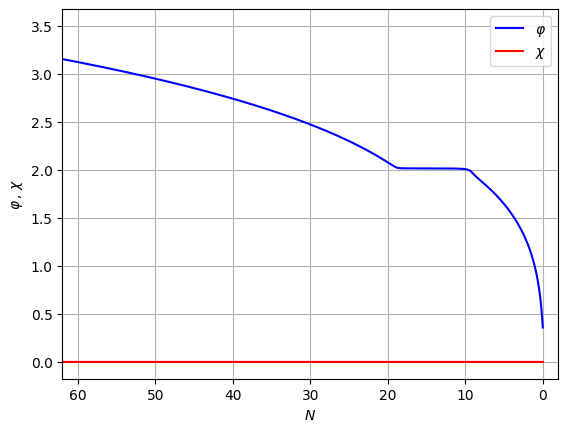

In [5]:
# Evolution of the background fields
plt.plot(Nx, back[:,1], 'b', label=f"$\\varphi$")
plt.plot(Nx, back[:,2], 'r', label=f"$\chi$") # this will be 0 in single-field
plt.xlabel('$N$')
plt.ylabel('$\\varphi\,,\,\chi$')
plt.xlim([62,-2])
plt.grid()
plt.legend(fontsize=10)

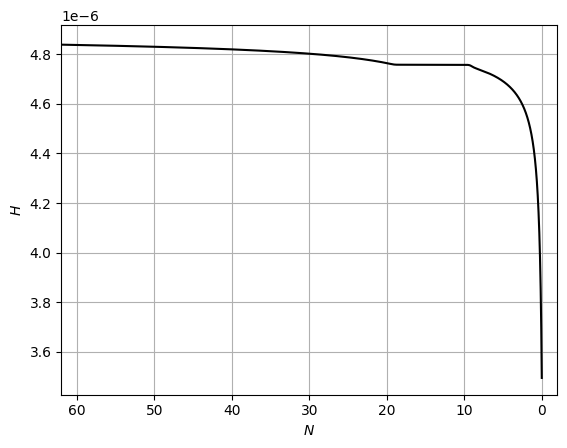

In [6]:
# Evolution of the Hubble parameter
plt.plot(Nx, H, 'k', label=f"$H$")
plt.xlabel('$N$')
plt.ylabel('$H$')
plt.xlim([62,-2])
plt.grid()

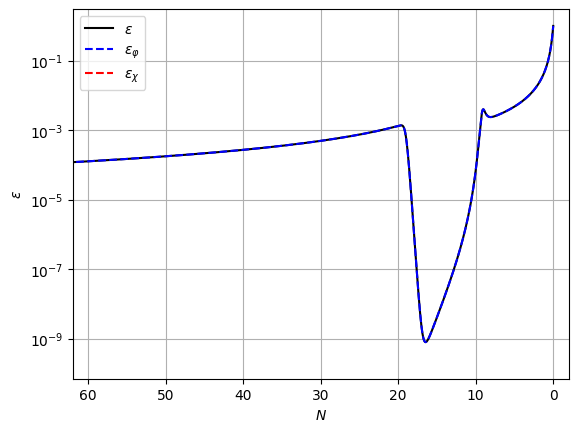

In [7]:
# Evolution of the first slow-roll parameter
plt.plot(Nx, eps, 'k', label=f"$\epsilon$")
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.plot(Nx, 0.5*back[:,3]**2/H**2, 'b--', label=f"$\epsilon_\\varphi$") # this will overlap eps in single-field
plt.plot(Nx, 0.5*back[:,4]**2/H**2, 'r--', label=f"$\epsilon_\chi$") # this will be 0 in single-field
plt.xlim([62,-2])
plt.yscale('log')
plt.grid()
plt.legend(fontsize=10)

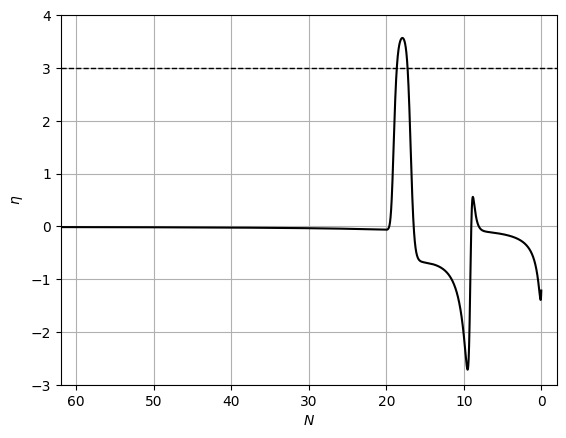

In [8]:
# Evolution of the second slow-roll parameter
plt.plot(Nx, eta, 'k', label=f"$\eta$")
plt.axhline(y=3, c='k', linestyle='--', linewidth=1) # USR threshold
plt.xlabel('$N$')
plt.ylabel('$\eta$')
plt.xlim([62,-2])
plt.ylim([-3,+4])
plt.grid()

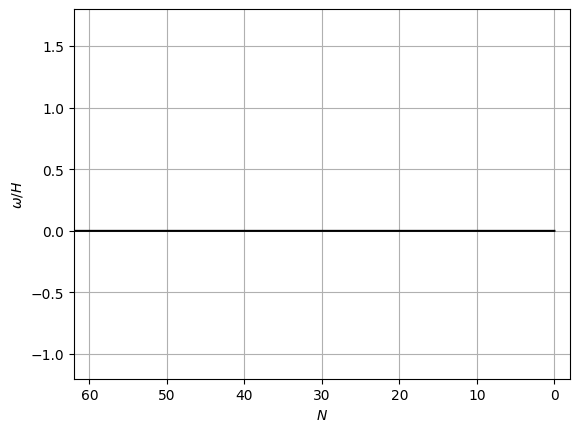

In [9]:
# Evolution of the turn rate (this will be 0 in single-field)
plt.plot(Nx, omega, 'k', label=f"$\omega/H$")
plt.xlabel('$N$')
plt.ylabel('$\omega/H$')
plt.xlim([62,-2])
plt.ylim([-1.2,+1.8])
plt.grid()

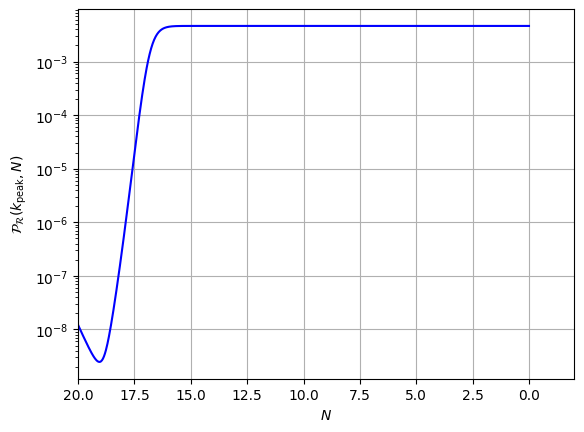

In [10]:
# Evolution of the curvature perturbation for the peak mode
prkN_peak = PRkN_(back, params, NExit=18)
plt.plot(prkN_peak[1], prkN_peak[0], 'b', label="${\\cal P}_{\\cal R}(k_{\\rm peak},N)$")
plt.xlabel('$N$')
plt.ylabel('${\\cal P}_{\\cal R}(k_{\\rm peak},N)$')
plt.xlim([20,-2])
plt.yscale('log')
plt.grid()

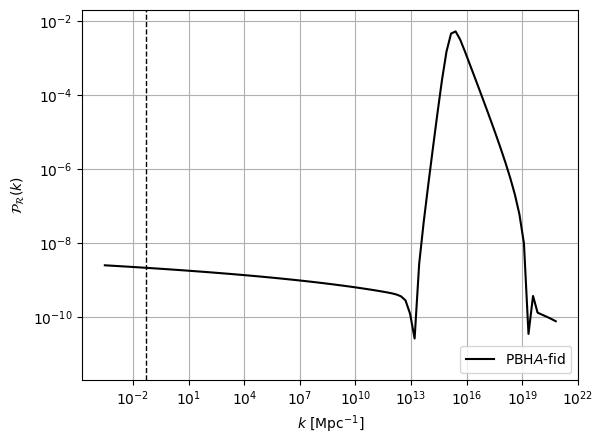

In [11]:
# Curvature power spectrum (as a function of k)
plt.plot(kPhys, calP, 'k-', label='PBH$A$-fid')
plt.axvline(x=0.05, c='k', linestyle='--', linewidth=1) # CMB scales
plt.xlabel('$k~\left[\\text{Mpc}^{-1}\\right]$')
plt.ylabel('${\cal P}_{\cal R}(k)$')
plt.yscale('log')
plt.xscale('log')
plt.ylim([2e-12,2e-2])
plt.legend(fontsize=10)
plt.grid()

### PBHspec model ($\chi$-PBH$A$-var in [2504.13251])

In [12]:
# Set the model parameters:
V0 = 8.3e-11
M = 0.5
A = 1.7373e-3
sigma = 1.81e-2
phid = 2.00*(1-4e-4)
mchi = 6e-7
params = np.array([Mp,V0,M,A,sigma,phid,mchi])

# Set the initial conditions:
phii = 3.5
chii = 3
dphii = 1e-10 # set the velocity to be non-zero to avoid numerical errors
dchii = 0.
initial = np.concatenate((np.array([phii,chii]),np.array([dphii,dchii])))

# Calculate the background evolution:
back = PyT.backEvolve(t, initial, params, tols, stop_at_end)
Ne = back[:,0]; Nend = Ne[-1]; Nx = Nend - Ne
print(f"Inflation ends after Nend={Nend:.2f} e-folds.")
H = hubble_(back, params)
eps = epsilon_(back, params)
eta = eta_(back, params, eps)
omega = omega_(back) # this will be identically zero in single-field

# Calculate CMB observables:
As, ns, alphas, r = CMBobs_(back, params, n_modes=nmodes, N_star=Nstar)
print(f"CMB observables:  As={As:.3e}  ns={ns:.5f}  alphas={alphas:.2e}  r={r:.2e}")

# Calculate the curvature power spectrum:
calP, kOut, NeHX = PRk_(back, params, n_modes=nmodes, N_star=Nstar+5, tols=tols)
kPhys = kOut * kCMB/kOut[find_index(NeHX, Nstar)] # normalise kOut to comoving physical scales

Evolving the background until eps_tot=1...44849
Inflation ends after Nend=89.70 e-folds.
CMB observables:  As=2.096e-09  ns=0.96850  alphas=-6.38e-04  r=2.61e-03


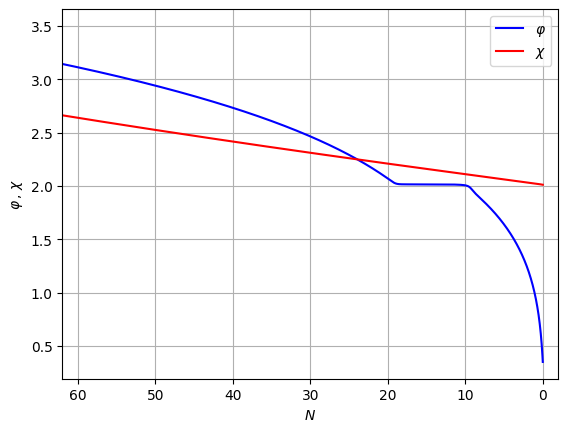

In [13]:
# Evolution of the background fields
plt.plot(Nx, back[:,1], 'b', label=f"$\\varphi$")
plt.plot(Nx, back[:,2], 'r', label=f"$\chi$") # this will be 0 in single-field
plt.xlabel('$N$')
plt.ylabel('$\\varphi\,,\,\chi$')
plt.xlim([62,-2])
plt.grid()
plt.legend(fontsize=10)

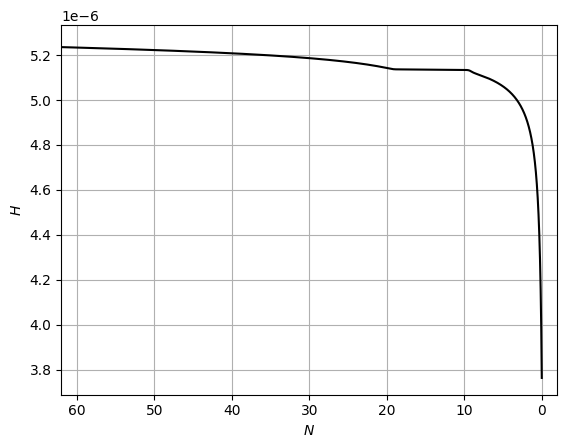

In [14]:
# Evolution of the Hubble parameter
plt.plot(Nx, H, 'k', label=f"$H$")
plt.xlabel('$N$')
plt.ylabel('$H$')
plt.xlim([62,-2])
plt.grid()

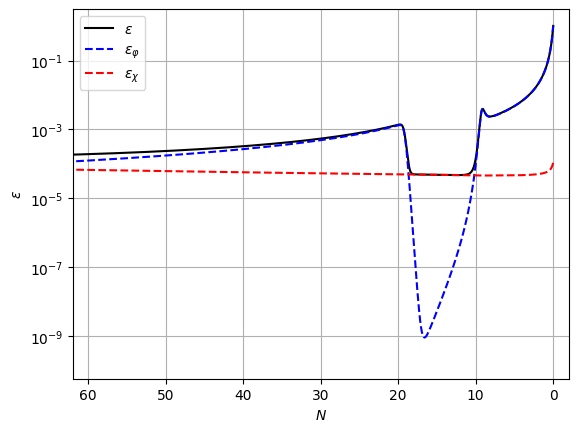

In [15]:
# Evolution of the first slow-roll parameter and its components
plt.plot(Nx, eps, 'k', label=f"$\epsilon$")
plt.plot(Nx, 0.5*back[:,3]**2/H**2, 'b--', label=f"$\epsilon_\\varphi$") # this will overlap eps in single-field
plt.plot(Nx, 0.5*back[:,4]**2/H**2, 'r--', label=f"$\epsilon_\chi$") # this will be 0 in single-field
plt.xlabel('$N$')
plt.ylabel('$\epsilon$')
plt.xlim([62,-2])
plt.yscale('log')
plt.grid()
plt.legend(fontsize=10)

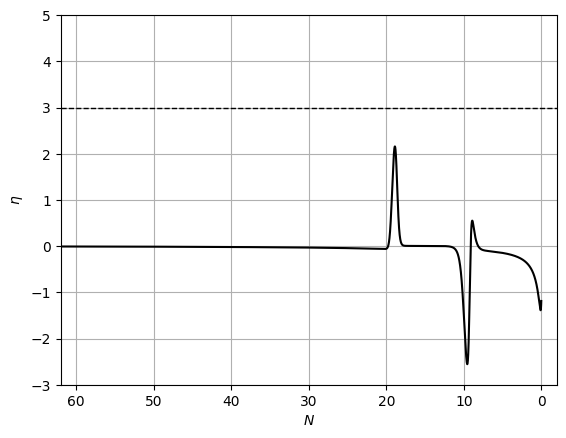

In [16]:
# Evolution of the second slow-roll parameter
plt.plot(Nx, eta, 'k', label=f"$\eta$")
plt.axhline(y=3, c='k', linestyle='--', linewidth=1) # USR threshold
plt.xlabel('$N$')
plt.ylabel('$\eta$')
plt.xlim([62,-2])
plt.ylim([-3,+5])
plt.grid()

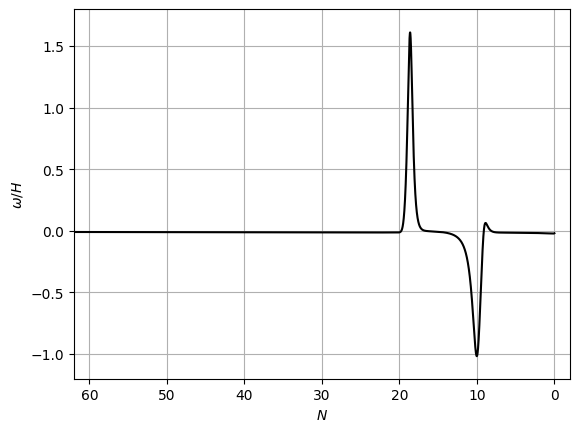

In [17]:
# Evolution of the turn rate (this will be 0 in single-field)
plt.plot(Nx, omega, 'k', label=f"$\omega/H$")
plt.xlabel('$N$')
plt.ylabel('$\omega/H$')
plt.xlim([62,-2])
plt.ylim([-1.2,+1.8])
plt.grid()

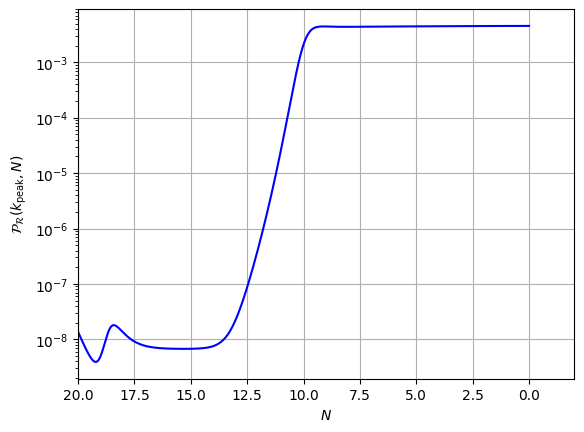

In [18]:
# Evolution of the curvature perturbation for the peak mode
prkN_peak = PRkN_(back, params, NExit=18)
plt.plot(prkN_peak[1], prkN_peak[0], 'b', label="${\\cal P}_{\\cal R}(k_{\\rm peak},N)$")
plt.xlabel('$N$')
plt.ylabel('${\\cal P}_{\\cal R}(k_{\\rm peak},N)$')
plt.xlim([20,-2])
plt.yscale('log')
plt.grid()

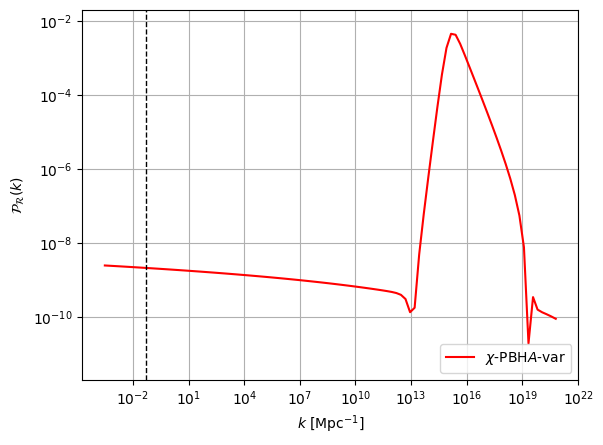

In [19]:
# Curvature power spectrum (as a function of k)
plt.plot(kPhys, calP, 'r-', label='$\chi$-PBH$A$-var')
plt.axvline(x=0.05, c='k', linestyle='--', linewidth=1) # CMB scales
plt.xlabel('$k~\left[\\text{Mpc}^{-1}\\right]$')
plt.ylabel('${\cal P}_{\cal R}(k)$')
plt.yscale('log')
plt.xscale('log')
plt.ylim([2e-12,2e-2])
plt.legend(fontsize=10)
plt.grid()

End of File